## Data pre-processing to conduct harmonics on ellipse data and gph anomaly data. 

In [19]:
#import statements
import datetime as dt
import numpy as np
import xarray as xr
import pickle

In [20]:
##GPH and ellipse data from within this folder
##weighted, gph at 500hPa averaged over the north atlantic region
infile = open("../data/NAO_gph500.p", 'rb') 
gph = pickle.load(infile)
infile.close()

##pvu at 10hPa over polar cap, 2.5 degree resolution
infile = open("pvu100_25deg.p", 'rb') 
pvu = pickle.load(infile)
infile.close()

In [21]:
##check size of all
print(gph.shape)
print(pvu.shape)

(63, 151)
(63, 181, 11, 145)


In [22]:
## check all for NaNs
if np.any(np.isnan(gph)) or np.any(np.isinf(gph)):
    print("NaN or Inf values found in gph!")

if np.any(np.isnan(pvu)) or np.any(np.isinf(pvu)):
    print("NaN or Inf values found in pvu!")

In [23]:
##calculate anomalies
dailymean_g = np.nanmean(gph,axis=1)
anom_g = np.zeros_like(gph)
for t in np.arange(gph.shape[1]):
        anom_g[:,t] = gph[:,t] - dailymean_g

dailymean_pv = np.nanmean(pvu,axis=1)
anom_pv = np.zeros_like(pvu)
for t in np.arange(pvu.shape[1]):
        anom_pv[:,t,:,:] = pvu[:,t,:,:] - dailymean_pv

In [24]:
print(anom_g.shape)
print(anom_pv.shape)

(63, 151)
(63, 181, 11, 145)


In [40]:
##conduct FFT smoothing on daily anomalies, 10-50 day periods
datafil_g = np.zeros_like(anom_g)

for y in np.arange(anom_g.shape[0]):
    d = anom_g[y,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=22,pers<=80))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil]=fftout[Ifil] #copy into array
    fftfil[-Ifil]=fftout[-Ifil] #conjugate symmetry
    
    datafil_g[y,:]=np.fft.ifft(fftfil,axis=0).real
################################################################################################
datafil_pv = np.zeros_like(anom_pv)

for y in np.arange(anom_pv.shape[0]):
    d = anom_pv[y,:,:,:] #extracts data for each year
        
    fftout=np.fft.fft(d,axis=0) #compute fast fourier over the days axis
    
    pers=d.shape[0]/np.arange(1, d.shape[0] + 1) ##calculating the period in days for frequency
    
    #Ifil=np.where(np.logical_and(pers>=14,pers<=60))[0] ##select subseasonal fluctuation
    Ifil=np.where(np.logical_and(pers>=22,pers<=80))[0] 
    
    fftfil=np.zeros_like(fftout)
    fftfil[Ifil,:,:]=fftout[Ifil,:,:] #copy into array
    fftfil[-Ifil,:,:]=fftout[-Ifil,:,:] #conjugate symmetry
    
    datafil_pv[y,:,:,:]=np.fft.ifft(fftfil,axis=0).real

In [41]:
import matplotlib.pyplot as plt 

In [42]:
datafil_pv.shape

(63, 181, 11, 145)

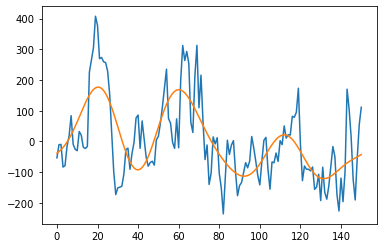

In [43]:
plt.plot(anom_g[59,:])
plt.plot(datafil_g[59,:])

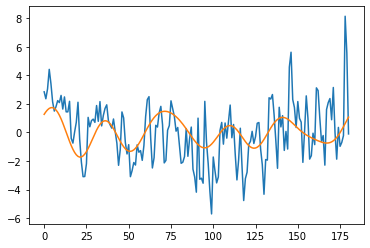

In [44]:
plt.plot(anom_pv[60,:,10,10])
plt.plot(datafil_pv[60,:,10,10])

In [35]:
##subtract off median from gph 

In [36]:
dailymed = np.nanmedian(datafil_g,axis=1)
med_g=np.zeros_like(datafil_g)
for t in np.arange(datafil_g.shape[1]):
     med_g[:,t] = datafil_g[:,t] - dailymed
med_g.shape

(63, 151)

In [37]:
datafil_g[0,120:]

array([-102.14897255, -106.55374676,  -96.83400986,  -76.2526255 ,
        -49.74055677,  -22.3517027 ,    1.97129913,   21.01686347,
         34.25515112,   42.29672385,   46.1745815 ,   46.77204373,
         44.60546889,   39.98952031,   33.43723901,   26.0448442 ,
         19.618887  ,   16.41525724,   18.53012054,   27.14447095,
         41.91198687,   60.75671054,   80.21650965,   96.27483589,
        105.43681467,  105.69650226,   97.05535937,   81.3902085 ,
         61.68952168,   40.90522841,   20.82188073])

In [38]:
med_g[0,120:]

array([-101.26488128, -105.66965549,  -95.94991859,  -75.36853423,
        -48.85646549,  -21.46761142,    2.8553904 ,   21.90095474,
         35.1392424 ,   43.18081513,   47.05867277,   47.65613501,
         45.48956017,   40.87361159,   34.32133028,   26.92893548,
         20.50297828,   17.29934851,   19.41421182,   28.02856222,
         42.79607815,   61.64080181,   81.10060092,   97.15892716,
        106.32090594,  106.58059354,   97.93945065,   82.27429977,
         62.57361295,   41.78931969,   21.705972  ])

In [39]:
###pickle out datasets
##pv
pickle.dump(datafil_pv, open("1122_filtered_pvu100.p", 'wb'))
##gph
pickle.dump(datafil_g, open("1122_filtered_gph.p", 'wb'))
pickle.dump(med_g, open("1122_filtered_gph_median.p", 'wb'))